In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from motion_planning_utils import *
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly
import pyclipper
from pyscipopt import *
import json


(5.5, 5.5)


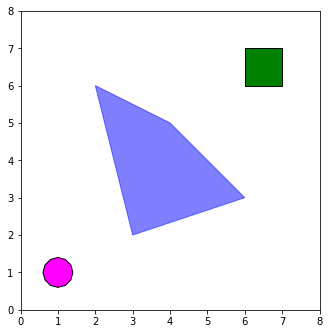

In [2]:
# Sample Problem
obstacles = [(3,2), (2,6), (4,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacles)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.4, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

In [3]:
def find_vertex_avg(obstacle):
    x_avg = sum([x[0] for x in obstacle])/len(obstacle)
    y_avg = sum([x[1] for x in obstacle])/len(obstacle)
    return (x_avg, y_avg)

In [5]:
# testing using SCIP via pyscipopt

start_point = (1,1)
goal_state = (7,7)
N = 120
timestep = .4
T = int(N * timestep)
time = list(range(1,N+1))
V_max = 1
M = 1e6
model = Model()
bounds = (0, 0, 8, 8)
obs_list = [[(3,2), (2,6), (4,5), (6,3)]]


# Set x,y decision vars
x,y,z = {},{},{}
for t in range(0,N+1):
    x[t] = model.addVar(lb=bounds[0], ub=bounds[2], name="x(%s)"%(t))
    y[t] = model.addVar(lb=bounds[1], ub=bounds[3], name="y(%s)"%(t))
        
# Set objective function
model.setObjective(quicksum((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) for t in time))

# Set initial conditions
model.addCons(x[0] == start_point[0])
model.addCons(y[0] == start_point[1])

# Set velocity constraint for each time period
for t in time:
    model.addCons((x[t] - x[t-1])*(x[t] - x[t-1]) + (y[t] - y[t-1])*(y[t] - y[t-1]) <= V_max**2 * timestep**2)
    
# Set goal state conditions
model.addCons(x[T] == goal_state[0])
model.addCons(y[T] == goal_state[1])
    
# Set Obstacle Constraints
for idx_obs, obs in enumerate(obs_list):
    for idx_v, vertex, in enumerate(obs):
        for t in time:
            z[(idx_obs, idx_v, t)] = model.addVar(name="z(%s,%s,%s)"%(idx_obs,idx_v,t), vtype="BINARY")
            
        vertex1 = obs[idx_v]
        vertex2 = obs[(idx_v + 1)%len(obs)] # grab next vertex and loop back to the first for last index
        delta_x = vertex2[0] - vertex1[0]
        delta_y = vertex2[1] - vertex1[1]
        vertex_avg = find_vertex_avg(obs) # known that avg of vertices lies inside convex polygon
        if delta_x != 0:  # check if line is vertical
            m = delta_y / delta_x
            b = vertex1[1] - m * vertex1[0]
            if vertex_avg[1] < m * vertex_avg[0] + b:  # then flip constraint
                model.addCons(-y[t] <= -m * x[t] - b + M*z[(idx_obs, idx_v, t)] for t in time)
            else:
                model.addCons(y[t] <= m * x[t] + b + M*z[(idx_obs, idx_v, t)] for t in time)
        else:
            if vertex_avg[0] <= vertex1[0]:  # then flip constraint
                model.addCons(-x[t] <= -vertex1[0] + M*z[(idx_obs, idx_v, t)] for t in time)
            else:
                model.addCons(x[t] <= vertex1[0] + M*z[(idx_obs, idx_v, t)] for t in time)
    for t in time:            
        model.addCons(quicksum(z[(idx_obs,v,t)] for v in range(len(obs))) <= (len(obs) - 1))

model.update()
model.optimize()

ValueError: Nonlinear objective functions are not supported!

In [56]:
path_list = []
for t in time:
#     x_val.append(x[t].x)
#     y_val.append(y[t].x)
    path_list.append((x[t].x, y[t].x))

(5.5, 5.5)
Obstacle Vertices: 
 [[(3, 2), (2, 6), (4, 5), (6, 3)]]


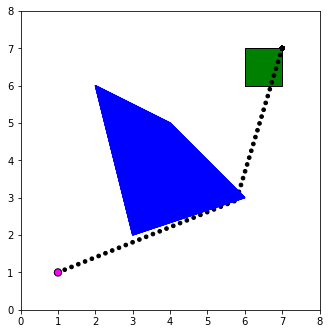

In [57]:
# Redefine obstacles with radius of droid; treat droid as a point robot
ax = plot_env([Polygon(obs_list[0])], start, goal, bounds)

for pt in path_list:
    t_pt = Point(pt).buffer(0.05, resolution=3)
    plot_poly(ax, t_pt, 'black')    


print('Obstacle Vertices: \n', obs_list)

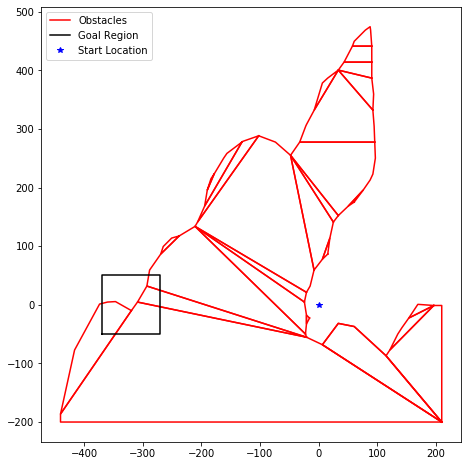

In [62]:
# Test JSON obstacle file

with open('notamoon.json') as f:
    ex_json_dict = json.load(f)
plt.figure(figsize=(14,8))

for obs in ex_json_dict['obstacles']:
    coord = np.array(obs['geometry']['coordinates'])
    plt.plot(coord[:,0],coord[:,1],'-r')

plt.gca().set_aspect('equal','box')
plt.draw()
line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(ex_json_dict['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')


In [68]:
obs_list_nm = []
for obs in ex_json_dict['obstacles']:
    coord = obs['geometry']['coordinates']
    obs_list_nm.append(coord)


In [70]:
len(obs_list_nm)

27

In [ ]:
def create_path_plan_model():
    
    
    
    return model